**<font size=5 color=black>决策树</font>**

**1** 以分类问题为例，介绍决策树分类的基本原理，并手动实现CART决策树分类算法

**2** 介绍决策树剪枝策略，并手动实现CCP剪枝算法

**3** 以鸢尾花分类问题为例，对比分析本文算法与sklearn的结果

In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
import numpy as np
import copy

**<font size=4 color=black>1 决策树分类的基本原理</font>** 

**<font size=3.5 color=black>1.1 基尼指数</font>** 

决策树学习的关键在于如何选择最优的划分特征和划分值。通常使用的标准有信息熵和基尼指数，本文使用基尼指数作为标准实现CART决策树算法，这与sklearn库中默认的评价标准一致，便于后续的结果对比。
对于数据集$D$： $$ Gini(D) = \sum_{k=1}^{K} p_k (1-p_k) = 1 - \sum_{k=1}^{K} p_k^2 \tag{1}$$ 
其中：$p_k$为第$k$类样本数占数据集$D$的总样本数的比例。

基尼指数反应了随机从样本中抽取两个样本，其标记不一致的概率。因此**基尼指数越小，数据集的纯度越高**。

纯度可以这样理解：一个数据集中的所有的样本标记都是一样的，那么该数据集最纯，此时基尼指数为0。

In [2]:
def unique_count(samples):
    """计算数据集中各类表标记所占的比例。该函数为计算基尼指数的辅助函数。
    Parameters
    ----------
    samples: ndarray of (n, n_features+1) 数据集, 默认最后一列为标记

    Returns
    -------
    counts: dict 数据集中各类表标记所占的比例
    """
    counts = {}
    for sample in samples:
        counts[int(sample[-1])] = counts.get(int(sample[-1]), 0) + 1
    return counts

In [3]:
def gini(samples):
    """计算数据集的基尼指数。
    Parameters
    ----------
    samples: ndarray of (n, n_features+1) 数据集, 默认最后一列为标记

    Returns
    -------
    out: float 数据集的基尼指数
    """
    total = len(samples)
    counts = unique_count(samples)
    out = 0
    for key in counts:
        p = counts[key] / total
        out += p * (1-p)
    return out

**<font size=3.5 color=black>1.2 特征选择</font>** 

我们已经知道使用基尼指数可以判断数据集的纯度，那么接下来的问题就是如何为决策树的根节点和中间节点选择最优的划分特征和划分值？

这里我们假设使用特征A，其某个取值为a，基于这个标准我们将数据集划分为$D_1$和$D_2=D-D_1$两部分。则在这一标准下，可以计算基尼指数：$$ Gini(D, A, a) = \frac{|D_1|}{|D|}Gini(D_1) + \frac{|D_2|}{|D|}Gini(D_2) \tag{2}$$ 

$Gini(D, A, a)$可以理解为按某一标准划分后的数据集$D$的纯度。因此，可以针对不同特征的不同取值，计算$Gini(D, A, a)$，取最小$Gini(D, A, a)$对应的特征及其取值作为当前节点的最优划分特征和划分值。

**<font color=red>说明：</font>**在具体的代码实现过程中，采用了一种“基尼增益”的标准：
$$ Gini\_gain = Gini(D) - Gini(D, A, a) \tag{3}$$ 
可以类比“信息增益”的概念。这么做的目的只是为了简明代码编写过程中的逻辑，其本质上与使用$Gini(D, A, a)$作为标准是一样的。因为对于某个$D$, $Gini(D)$是定值，取最大的$Gini\_gain$与取最小的$Gini(D, A, a)$能够得到相同的最优划分特征和划分值。

In [4]:
def branch(samples, col, v):
    """划分当前节点的数据集，得到划分后的左右子树的数据集。
    Parameters
    ----------
    samples: ndarray of (n, n_features+1) 数据集, 默认最后一列为标记
    col: int 划分特征的索引
    v: float 划分特征的某一取值

    Returns
    -------
    (samples1, samples2): (ndarray, ndarray) 左右子树的数据集
    """
    tb_samples = []  # 存放左子树样本
    fb_samples = []  # 存放右子树样本
    for sample in samples:
        if sample[col] <= v:  # 小于等于阈值的划分到左子树
            tb_samples.append(sample)
        else:  # 大于阈值的划分到右子树
            fb_samples.append(sample)
    return (np.array(tb_samples), np.array(fb_samples))

**<font size=3.5 color=black>1.3 决策树学习</font>** 

这部分采用递归的方法构建CART决策树。

In [5]:
class Node:
    """Node类存放了决策树中的每个节点的信息。"""

    def __init__(self, divide_col=None, divide_value=None, gini_value=None,
                 true_branch=None, false_branch=None, divide_result=None):
        self.divide_col = divide_col  # int 划分特征的索引
        self.divide_value = divide_value  # float 划分值
        self.gini_value = gini_value  # float 当前节点的gini值
        self.true_branch = true_branch  # class 左子树(满足divide_value<=v)
        self.false_branch = false_branch  # class 右子树(不满足divide_value<=v)
        self.divide_result = divide_result  # dict 划分结果

In [6]:
def build_tree(samples):
    """递归构建决策树。
    Parameters
    ----------
    samples: ndarray of (n, n_features+1) 数据集, 默认最后一列为标记

    Returns
    -------
    class 训练完成的决策树
    """
    gini_samples = gini(samples)  # 当前数据集的基尼指数
    gini_gain = 0.0  # 初始化基尼增益
    best_criterion = (None, None)  # 初始化划分标准
    best_sets = (None, None)  # 初始化划分后的左右子树的数据集

    for col in range(samples.shape[1]-1):
        # 特征的唯一取值个数只有1个时, 对划分数据集没有作用
        if len(set(samples[:, col])) < 2:
            continue
        else:
            # 二分法确定每个特征的划分值
            sort_values = np.array(sorted(set(samples[:, col])))
            divide_values = (sort_values[:-1] + sort_values[1:]) / 2
            # 遍历计算Gini(D, A, a)
            for v in divide_values:
                (tb_samples, fb_samples) = branch(samples, col, v)
                p_tb = len(tb_samples) / len(samples)
                gini_col_v = p_tb * gini(tb_samples) + \
                    (1-p_tb) * gini(fb_samples)
                # 取基尼增益最大的特征和值作为最优划分特征和划分值
                if gini_samples - gini_col_v > gini_gain:
                    gini_gain = gini_samples - gini_col_v
                    best_criterion = (col, v)
                    best_sets = (tb_samples, fb_samples)
    # 递归条件
    if gini_gain > 0:
        tb = build_tree(best_sets[0])
        fb = build_tree(best_sets[1])
        return Node(divide_col=best_criterion[0], divide_value=best_criterion[1],
                    gini_value=gini_samples, true_branch=tb, false_branch=fb,
                    divide_result=unique_count(samples))
    # 递归终止条件--基尼增益为0
    else:
        return Node(gini_value=gini_samples, divide_result=unique_count(samples))

**二分法是针对连续值的处理方法**。由于sklearn库实现的是CART决策树，并对输入数据都默认当作连续值处理，因此这里

为了后面进行比较，不再针对离散型特征单独处理。此外，本文案例所使用的鸢尾花数据集的各个特征均为连续型，因此

若遇到（'男'、'女'）等离散型数据，可以考虑添加相关函数作对应处理。

**当基尼增益为0时，递归终止。**这意味着，算法构建了一棵完整的决策树，即划分到每个叶节点最纯（无杂质，只有一类样

本）为止。这种做法通常会造成过拟合问题，一般情况下会设定基尼增益小于某一阈值即停止，或者采取其他的决策树

剪枝策略。这里为了演示，首先让决策树完整生长，重点在于理解决策树算法的处理过程，后面章节会给出剪枝方法。

In [7]:
def tree2text(tree):
    """打印输出决策树。
    Parameters
    ----------
    tree: class 训练完成的决策树
    """
    if tree.divide_col is None:
        print('gini=' + str(tree.gini_value) + '\n' +
              'samples=' + str(sum(tree.divide_result.values())) + '\n' +
              'value=' + str(tree.divide_result))
    else:
        print('x[{}]<={}'.format(tree.divide_col, tree.divide_value) + '\n' +
              'gini=' + str(tree.gini_value) + '\n' +
              'samples=' + str(sum(tree.divide_result.values())) + '\n' +
              'value=' + str(tree.divide_result))
        print('T:')
        tree2text(tree.true_branch)
        print('F:')
        tree2text(tree.false_branch)

**<font size=3.5 color=black>1.4 决策树预测</font>**

给定一个未知标记的样本，利用前述构建的决策树，预测输出样本标记。

In [8]:
def predict(tree, x):
    """输入学习完成的决策树和未知标记的样本，预测输出样本标记。
    Parameters
    ----------
    tree: class 训练完成的决策树
    x: ndarray of (1, n_features) 未知标记的样本

    Returns
    -------
    pre: int 预测结果（对应于数据集的label编码）
    """
    if tree.divide_col is None:
        sort_result = sorted(tree.divide_result.items(),
                             key=lambda kv: kv[1], reverse=True)
        return sort_result[0][0]
    else:
        x_col_v = x[tree.divide_col]
        if x_col_v <= tree.divide_value:
            pre = predict(tree.true_branch, x)
        else:
            pre = predict(tree.false_branch, x)

    return pre

**<font size=4 color=black>2 决策树剪枝</font>** 

CART决策树的剪枝最小成本复杂度剪枝（Minimal Cost-Complexity Pruning, CCP）算法。

**2.1 基本定义**<br>
+ **树的成本复杂度：**$$ R_\alpha(T) = R(T) + \alpha|T|$$
其中：$\alpha$为平衡拟合精度与模型复杂度的参数；$|T|$为树$T$的叶节点个数；$R(T)$传统上定义为树$T$的叶节点的整体错分率，但在sklearn中的计算方法是加权叶节点基尼指数/信息熵。<br>
+ **单个节点t的成本复杂度：**$$ R_\alpha(t) = R(t) + \alpha $$
+ **以$t$为根节点子树的成本复杂度：**$$ R_\alpha(T_t) = R(T_t) + \alpha|T_t| $$
+ **令$R(T_t)=R(t)$，则当前节点$t$的剪枝阈值：**$$\alpha_t = \frac{R(t)-R(T_t)}{|T_t|-1}$$
当$\alpha > \alpha_t$，剪枝比不剪枝要好，即$R(T_t) > R(t)$；当$\alpha < \alpha_t$，不剪枝比剪枝要好，即$R(T_t) < R(t)$；当$\alpha = \alpha_t$，$R(T_t) = R(t)$，但$t$比$T_t$的节点少，所以也是剪枝比不剪枝要好。

**2.2 剪枝流程**

(1) 人为**设定一个ccp_alpha参数**（可以参考sklearn中这个参数的含义）<br>
(2) 遍历整体树的所有非叶节点，**计算每个非叶节点的剪枝阈值**$\alpha$<br>
(3) 找到**$\alpha_{min}$**对应的子树进行剪枝，即仅保留该子树的根节点，进而得到剪枝后的最优树<br>
(4) **在上一轮剪枝后的最优树的基础上**，重复(2)(3)步骤，直到当前轮次的**$\alpha_{min}>ccp\_alpha$**，停止剪枝。<font color=red>注意：也可以不设置ccp_alpha参数，直到剪枝到只剩根节点为止。</font><br><br>
**以下图的树举例说明：**
<img src="../src/decisionTree.png" width=320, heigth=240>
本文采用的计算方法与sklearn相同，即：<br>
$R(T_{t_1}) = \frac{43}{46} \times 0.0 + \frac{1}{46} \times 0.0 + \frac{2}{46} \times 0.0 = 0.0$，
$R(t_1) = \frac{46}{46} \times 0.043 = 0.043$，
$\alpha_1 = \frac{0.043-0.0}{3-1} = 0.0215 $；<br>
$R(T_{t_2}) = \frac{1}{46} \times 0.0 + \frac{2}{46} \times 0.0 = 0.0$，
$R(t_2) = \frac{3}{46} \times 0.444 = 0.029$，
$\alpha_2 = \frac{0.029-0.0}{2-1} = 0.029 $<br>
$\alpha_{min} = \alpha_1 = 0.0215 $<br>
$R_{\alpha_{min}}(T) = \frac{43}{46} \times 0.0 + \frac{1}{46} \times 0.0 + \frac{2}{46} \times 0.0 + 0.0215 \times 3 = 0.0645 $<br>
$R_{\alpha_{min}}(T-T_{t_1}) = \frac{46}{46} \times 0.043 + 0.0215 = 0.0645 $<br>
$R_{\alpha_{min}}(T-T_{t_2}) = \frac{3}{46} \times 0.444 + \frac{43}{46} \times 0.0 + 0.0215 \times 2 = 0.072 $<br>
可以发现，在$\alpha_{min}$下，未剪枝的整体树$T$和剪掉$T_{t_1}$后的树，成本复杂度相同，而剪掉$T_{t_2}$后的树的成本复杂度比前两者都高。由于剪掉$T_{t_1}$后的树比未剪枝的整体树$T$结构更为简单（叶节点少），因此最终剪掉$T_{t_1}$后的树为$\alpha_{min}$下的最优树。完成该轮剪枝后，发现恰好只剩一个根节点，因此不再继续下一轮次的剪枝。<br>

**2.3 剪枝思考**<br>
<font color=blue>1：为什么对$\alpha_{min}$对应的子树进行剪枝后，得到的剪枝后的树为最优树？</font><br>
(1)首先要清楚每轮的最优树是和每轮的$\alpha_{min}$对应的。对于当前轮次的$\alpha_{min}$，其意味着除了对应$min\_\alpha$的节点，其他节点都不倾向剪枝（因为其他节点的剪枝阈值比$\alpha_{min}$都大，若剪枝会使得$R_{\alpha_{min}}(t)>R_{\alpha_{min}}(T_t)$）。因此对于$\alpha_{min}$，剪枝$\alpha_{min}$对应的节点得到的树相比于剪枝其他节点得到的树是最优的，也就是成本复杂度最小的。<br>
(2)根据树的成本复杂度公式可知，我们的目标是在一个$\alpha$下，找到剪枝后成本复杂度最小的树。当选择$\alpha_{min}$的节点进行剪枝得到的树，其成本复杂度要比选择剪枝其他节点得到的树小，同时又比未剪枝的整体树结构简单，因此为$\alpha_{min}$下的最优树。<br>
<font color=blue>2：为什么要选择$\alpha_{min}$对应的子树进行剪枝？</font><br>
这是由CART决策树递归剪枝算法本身决定的。试想：若第一轮就剪掉了$\alpha_{max}$对应的子树，有可能一下子就剪的只剩整体树的根节点，无法再继续递归，也就无法得知剪枝其他节点得到的树效果如何，因此需要每一轮剪$\alpha_{min}$对应的子树，循序渐进，$\alpha_{min}$逐渐增大，直至不满足$\alpha_{min}>ccp\_alpha$条件或剪得只剩整体树的根节点。

In [9]:
def get_leaves(root):
    """获取树的所有叶结点（采用队列方法遍历二叉树的节点）。
    Parameters
    ----------
    root: class 整体树或子树

    Returns
    -------
    leaves: list 树的叶节点列表
    """
    leaves = []
    queue = [root]
    while queue:
        node = queue.pop(0)
        if node.divide_col is None:
            leaves.append(node)
        if node.true_branch:
            queue.append(node.true_branch)
        if node.false_branch:
            queue.append(node.false_branch)

    return leaves

In [10]:
def get_cost(root):
    """计算树的成本。
    Parameters
    ----------
    root: class 整体树或子树

    Returns
    -------
    R_t: 将root作为单个叶节点的成本
    R_T: 以root为根的子树的成本
    len(leaves): int 树的叶节点个数
    """
    total_samples = len(samples)
    root_samples = sum(root.divide_result.values())
    R_t = root_samples / total_samples * root.gini_value

    R_T = 0
    leaves = get_leaves(root)
    for leaf in leaves:
        leaf_samples = sum(leaf.divide_result.values())
        R_T += leaf_samples / total_samples * leaf.gini_value

    return R_t, R_T, len(leaves)

In [11]:
def prune(tree, ccp_alpha=0.0):
    """采用最小成本复杂度算法对决策树进行剪枝。
    Parameters
    ----------
    tree: class 训练得到的决策树
    ccp_alpha: ccp算法的阈值，当alpha大于该值时，停止剪枝。默认值为0.0
    """
    alphas = []  # 存储每一轮修剪的有效alpha值
    subtree = []  # 被剪掉的子树，对应alphas
    queue = [tree]
    # 遍历每个非叶节点，并计算对应alpha
    while queue:
        root = queue.pop(0)
        if root.divide_col is not None:
            R_t, R_T, n_leaf = get_cost(root)
            alpha = (R_t-R_T) / (n_leaf-1)
            alphas.append(alpha)
            subtree.append(root)
        if root.true_branch:
            queue.append(root.true_branch)
        if root.false_branch:
            queue.append(root.false_branch)

    min_alpha = min(alphas)
    # 修剪条件
    if min_alpha < ccp_alpha:
        # 修剪掉满足条件的节点的左右子树
        pruned = subtree[alphas.index(min_alpha)]
        pruned.true_branch = None
        pruned.false_branch = None
        pruned.divide_col = None
        pruned.divide_value = None
        pruned_tree = tree
        min_alpha = prune(pruned_tree, ccp_alpha)  # 继续修剪，直至条件不满足

    return min_alpha

**2.3 剪枝路径**

在sklearn中我们可以通过**get_cost_pruning_path**获取到所有有效的ccp_alpha参数列表。本文给出一些函数以实现sklearn中的类似效果。

在2.2中通过设定一个ccp_alpha参数来实现剪枝，但ccp_alpha的确定需要人为给出。我们希望充分利用数据获取到所有有效的ccp_alpha值，这就需要从整体树开始修剪，直到只剩一个根节点，找出每一轮修剪的$\alpha_{min}$，以及对应剪枝后的树。进而可以对所有轮次剪枝后的树，使用独立验证数据集进行交叉验证，最终选择最优的那棵树。

In [12]:
def get_impurity(root):
    """计算树的杂质。公式同get_cost函数中R_T的计算方法。
    Parameters
    ----------
    root: class 整体树或子树

    Returns
    -------
    impurity: float 树的杂质
    """
    total_samples = len(samples)
    root_samples = sum(root.divide_result.values())

    impurity = 0
    leaves = get_leaves(root)
    for leaf in leaves:
        leaf_samples = sum(leaf.divide_result.values())
        impurity += leaf_samples / total_samples * leaf.gini_value

    return impurity

In [13]:
def get_pruning_path(tree):
    """按CCP算法剪枝，获取有效的ccp_alpha参数列表，和每个ccp_alpha参数对应的
    剪枝后的最优树及其杂质。
    Parameters
    ----------
    tree: class 整体树

    Returns
    -------
    valid_alphas: [float] 从整体树依次进行剪枝，直到只剩一个根节点，过程中所有有效的ccp_alpha值
    impurities: [float] 每个ccp_alpha值对应的剪枝后的最优树的杂质
    pruned_trees: [class] 每个ccp_alpha值对应的剪枝后的最优树
    """
    def one_prune(tree):
        """采用最小成本复杂度算法对决策树进行一次剪枝。
        Parameters
        ----------
        tree: class 训练得到的决策树

        Returns
        -------
        min_alpha: float tree中所有非叶节点中最小的alpha值
        pruned_tree: min_alpha对应的剪枝后的最优树
        """
        if tree.divide_col is None:
            return None, None
        else:
            alphas = []
            subtree = []
            queue = [tree]
            while queue:
                root = queue.pop(0)
                if root.divide_col is not None:
                    R_t, R_T, n_leaf = get_cost(root)
                    alpha = (R_t-R_T) / (n_leaf-1)
                    alphas.append(alpha)
                    subtree.append(root)
                if root.true_branch:
                    queue.append(root.true_branch)
                if root.false_branch:
                    queue.append(root.false_branch)

            min_alpha = min(alphas)
            pruned = subtree[alphas.index(min_alpha)]
            pruned.true_branch = None
            pruned.false_branch = None
            pruned.divide_col = None
            pruned.divide_value = None
            pruned_tree = tree

            return min_alpha, pruned_tree

    if tree.divide_col is None:
        return [-1], [get_impurity(tree)], [tree]  # -1表示只有一个根节点，无法再继续剪枝
    else:
        valid_alphas = [0]
        pruned_trees = []
        impurity = get_impurity(tree)
        impurities = [impurity]

        min_alpha, pruned_tree = one_prune(tree)
        while pruned_tree is not None:
            valid_alphas.append(min_alpha)
            pruned_trees.append(pruned_tree)
            impurity = get_impurity(pruned_tree)
            impurities.append(impurity)
            min_alpha, pruned_tree = one_prune(pruned_tree)

        return valid_alphas, impurities, pruned_trees

**<font size=4 color=black>3 鸢尾花分类案例</font>** 

**<font size=3.5 color=black>3.1 使用本文算法</font>**

In [14]:
# 加载鸢尾花数据集
iris = load_iris()
X = iris.data
y = iris.target
samples = np.hstack((X, y[:, np.newaxis]))

In [15]:
# 构建决策树
mytree = build_tree(samples)

# 输出决策树文本
print('决策树文本输出结果：')
tree2text(mytree)
print('-----------------')

# 决策树预测
pre = predict(mytree, samples[1, :-1])
print('预测结果：', pre)
print('-----------------')

# 决策树剪枝路径
mytree_copy1 = copy.deepcopy(mytree)  # 创建mytree的副本
valid_alphas, impurities, pruned_trees = get_pruning_path(mytree_copy1)
print('决策树剪枝路径')
print('valid_alphas:\n', valid_alphas)
print('impurities:\n', impurities)
print('-----------------')

# 决策树剪枝
mytree_copy2 = copy.deepcopy(mytree)
min_alpha = prune(mytree_copy2, ccp_alpha=0.007)
print('停止剪枝时：min_alpha =', min_alpha)
print('剪枝后的决策树：')
tree2text(mytree_copy2)

决策树文本输出结果：
x[2]<=2.45
gini=0.6666666666666667
samples=150
value={0: 50, 1: 50, 2: 50}
T:
gini=0.0
samples=50
value={0: 50}
F:
x[3]<=1.75
gini=0.5
samples=100
value={1: 50, 2: 50}
T:
x[2]<=4.95
gini=0.1680384087791495
samples=54
value={1: 49, 2: 5}
T:
x[3]<=1.65
gini=0.04079861111111115
samples=48
value={1: 47, 2: 1}
T:
gini=0.0
samples=47
value={1: 47}
F:
gini=0.0
samples=1
value={2: 1}
F:
x[3]<=1.55
gini=0.4444444444444445
samples=6
value={1: 2, 2: 4}
T:
gini=0.0
samples=3
value={2: 3}
F:
x[0]<=6.95
gini=0.4444444444444445
samples=3
value={1: 2, 2: 1}
T:
gini=0.0
samples=2
value={1: 2}
F:
gini=0.0
samples=1
value={2: 1}
F:
x[2]<=4.85
gini=0.04253308128544422
samples=46
value={1: 1, 2: 45}
T:
x[0]<=5.95
gini=0.4444444444444445
samples=3
value={1: 1, 2: 2}
T:
gini=0.0
samples=1
value={1: 1}
F:
gini=0.0
samples=2
value={2: 2}
F:
gini=0.0
samples=43
value={2: 43}
-----------------
预测结果： 0
-----------------
决策树剪枝路径
valid_alphas:
 [0, 0.00652173913043478, 0.008888888888888889, 0.01305555555

**<font size=3.5 color=black>2.2 使用sklearn库</font>** 

**---jupyter notebook中使用graphviz**---

1.pip install graphviz

2.下载安装[graphviz软件](https://graphviz.gitlab.io/_pages/Download/Download_windows.html)

3.添加系统变量(软件安装路径示例：D:\Graphviz\bin)

4.重启jupyter notebook

报错解决：https://www.jianshu.com/p/8ede808e6f92

In [16]:
# 决策树学习
# random_state是为了每次学习获得一棵固定的决策树，若不设置，则会在每次选择划分特征前
# 随机打乱特征顺序。例如当使用某两个特征进行划分具有相同的gini值时，随机选择其中一个特征，
# 这样就会造成每次训练得到不同的决策树。更多细节可以参考3。
clf = tree.DecisionTreeClassifier(random_state=15).fit(X, y)

# 打印文本格式决策树
tree_text = tree.export_text(clf)
print(tree_text)

|--- feature_2 <= 2.45
|   |--- class: 0
|--- feature_2 >  2.45
|   |--- feature_3 <= 1.75
|   |   |--- feature_2 <= 4.95
|   |   |   |--- feature_3 <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  1.65
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  4.95
|   |   |   |--- feature_3 <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- feature_3 >  1.55
|   |   |   |   |--- feature_0 <= 6.95
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  6.95
|   |   |   |   |   |--- class: 2
|   |--- feature_3 >  1.75
|   |   |--- feature_2 <= 4.85
|   |   |   |--- feature_0 <= 5.95
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  5.95
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  4.85
|   |   |   |--- class: 2



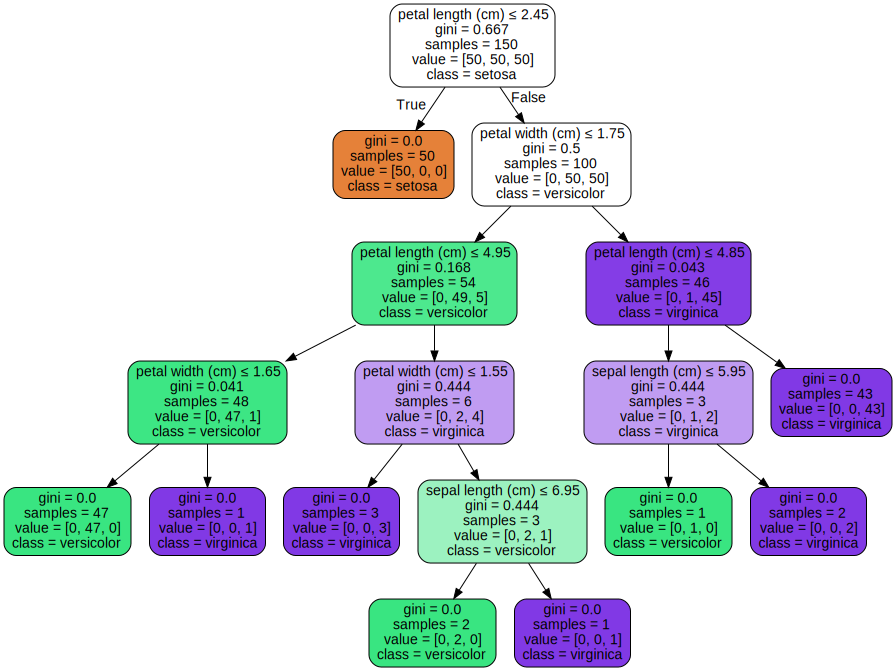

In [17]:
# 图形化决策树
# tree.plot_tree(clf)  # 在jupyter里显示不清楚, 故利用graphviz可视化决策树
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

ccp_alphas:
 [0.         0.00652174 0.00888889 0.01305556 0.02966049 0.25979603
 0.33333333]
impurities:
 [0.         0.01304348 0.03082126 0.04387681 0.07353731 0.33333333
 0.66666667]


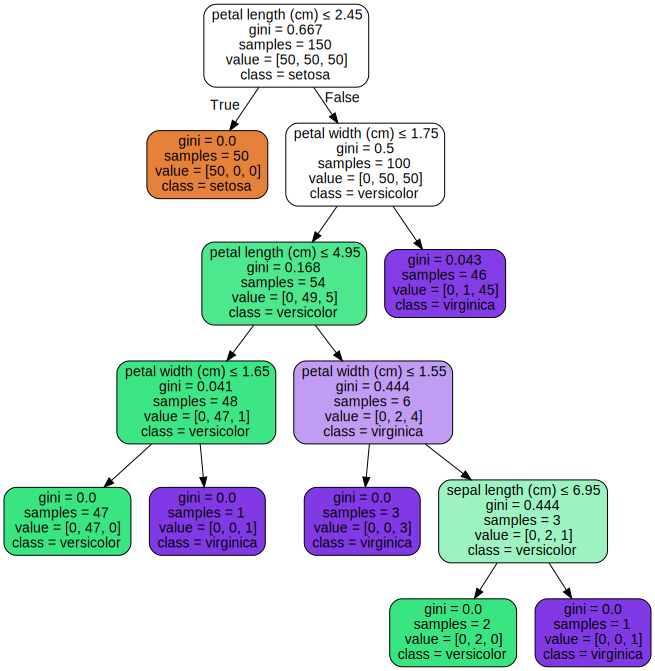

In [18]:
# 成本复杂度剪枝路径，可参考此结果确定合适的ccp_alpha参数
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('ccp_alphas:\n', ccp_alphas)
print('impurities:\n', impurities)

# 剪枝
clf2 = tree.DecisionTreeClassifier(random_state=15, ccp_alpha=0.007).fit(X, y)
dot_data2 = tree.export_graphviz(clf2, out_file=None,
                                 feature_names=iris.feature_names,
                                 class_names=iris.target_names,
                                 filled=True, rounded=True,
                                 special_characters=True)
graph2 = graphviz.Source(dot_data2)
graph2

可以发现使用sklearn的结果，无论是剪枝前的决策树、剪枝后的决策树、剪枝路径等与本文算法均一致。<br><br>
<font color=red>*注：虽然本文实现了CART决策树的学习、预测、剪枝等算法，并取得了一定效果，但更多是帮助学习理解CART决策树的基本原理和处理过程，关于决策树的更多细节可以从参考中学习。</font>

**<font size=4 color=black>参考</font>** 

1 李航. (2012) 统计学习方法. 清华大学出版社, 北京.

2 [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)